### Section 3: Data Modelling | Optimization algorithm

One of your clients is facing challenges with conversions (i.e. acquire new customers). Last year, it spent just under £74 million in various media channels such as cinema, digital, print, radio, social and TV. Details of this spend and number of new customers acquired are stored at https://goo.gl/t3kZA6. Could you design and develop an optimisation algorithm to fill in the missing numbers (marked with question mark) ensuring that that the recommended budgets meet the constraints i.e. min budget and max budget.

In [1]:
import torch
import torchvision
import numpy as np
import pandas as pd

# data sample
data = pd.read_excel('../data/Optimisation_Exercise.xlsx')
pt = pd.pivot_table(data, index=['Media Channel'], aggfunc=sum)
pt['ROI (n_clients)'] = pt['Customer Acquisition'] / pt['Advertising Spend (in millions)']
pt.reset_index(inplace=True)

# pt.style.format({"Advertising Spend (in millions)": ".2f%"})
# pt.style.format({"ROI (n_clients)":"{:,.2f}"})
pt

Media Channel  Advertising Spend (in millions)  Customer Acquisition  \
0        Cinema                          1.84375                 10300   
1       Digital                         32.06250                 88950   
2         Print                          7.75000                 17725   
3         Radio                         14.67250                 88500   
4        Social                          2.11455                 14850   
5            TV                         15.31250                 66650   

   ROI (n_clients)  
0      5586.440678  
1      2774.269006  
2      2287.096774  
3      6031.691941  
4      7022.770802  
5      4352.653061

#### Basic approach
- Treating the investment data per channel in an aggregated form over the provided period of time.
E.g. Total investment in Cinema has been ~1.8M leading to the acquisition of ~10.3k new customer. In the next period we assume to keep the investment amount in a range of [min - max]M€.

In [24]:
from scipy.optimize import linprog

# we will call the target investment by channel: x0, x2, ..., x5
c = -pt['ROI (n_clients)'].values # or .as_matrix()

A = [[1, 1, 1, 1, 1, 1]]
b = [73.7558]

x0_bounds = (1.475, 2.2125)
x1_bounds = (25.65, 38.475)
x2_bounds = (6.2, 9.3)
x3_bounds = (11.738, 17.607)
x4_bounds = (1.69164, 2.53746)
x5_bounds = (12.25, 18.375)

res = linprog(c, A_eq=A, b_eq=b, bounds=(x0_bounds, 
                                         x1_bounds, 
                                         x2_bounds, 
                                         x3_bounds,
                                         x4_bounds,
                                         x5_bounds), options={"disp": True})
print(res)

Optimization terminated successfully.
         Current function value: -304956.547930
         Iterations: 13
     fun: -304956.54792982456
 message: 'Optimization terminated successfully.'
     nit: 13
   slack: array([  0.7375 ,   0.     ,   3.1    ,  11.65116,   0.     ,   0.     ,
         5.869  ,   0.     ,   0.84582,   0.     ,   6.125  ,   0.     ])
  status: 0
 success: True
       x: array([  2.2125 ,  26.82384,   6.2    ,  17.607  ,   2.53746,  18.375  ])


##### Solution

In [25]:
pt_res = pd.DataFrame()
pt_res['Media Channel'] = pt['Media Channel'] 
pt_res['Advertising Spend (in millions)'] = res.x
pt_res['Customer Acquisition'] = res.x * pt['ROI (n_clients)'].values
pt_res

Media Channel  Advertising Spend (in millions)  Customer Acquisition
0        Cinema                          2.21250           12360.00000
1       Digital                         26.82384           74416.54793
2         Print                          6.20000           14180.00000
3         Radio                         17.60700          106200.00000
4        Social                          2.53746           17820.00000
5            TV                         18.37500           79980.00000

#### 'Incremental' approach
- [Although this is not consistent with the provided table to fill as a result of the exercise] Regarding how the data is provided it may be fair to assume that it corresponds to aggregated values of investment and customer acquisition, spread over a temporal framework. 

That assumption would lead to the following ROI curves per channel (in aggregatted terms).

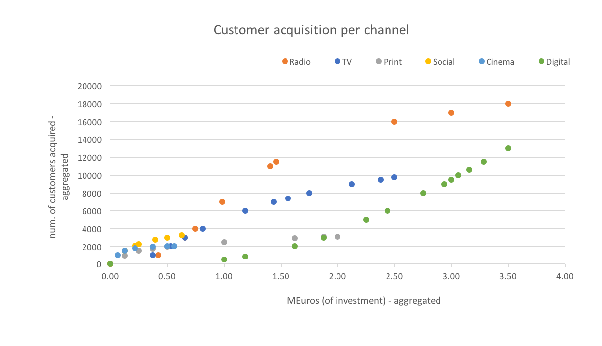

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import os

img=mpimg.imread('../optimisation_exercise.png')
plt.figure(figsize=(10, 12))
plt.axis('off')
plt.imshow(img)

Under that assumption, and with a different or more flexible problem scope, further issues can be targetted:

- Channel saturation: can we optimise the investment per channel in order not only to maximise ROI but also the effectiveness of each channel? That is, if we can flexibilise the constraints (investment max. and min. values) adding +/- margings to the limits, we may be interested in targetting the steepest range of each curve per channel within the investment boundary constraints. 

- Customer saturation: if provided with a temporal framework we should aim to model the interaction between marketing channels.
    
- Customer life cycle: in addition, we can try to maximise ROI + custumer retention - e.g.: 'It is more probable that an acquired customer tries a product for more than 3 days if targetted with Radio + Digital than only Radio', and how the temporal interaction between channels affect the churn rate.
    
- Etc.